In [1]:
#Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score

### Preparação dos Dados

In [2]:
df = pd.read_csv('dados_tratados.csv')
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Contas_Diarias,tenure_category
0,0002-ORFBO,0.0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667,0-12 meses
1,0003-MKNFE,0.0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667,0-12 meses
2,0004-TLHLJ,1.0,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333,0-12 meses
3,0011-IGKFF,1.0,Male,1,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667,13-24 meses
4,0013-EXCHZ,1.0,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667,0-12 meses


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Churn             7032 non-null   float64
 2   gender            7032 non-null   object 
 3   SeniorCitizen     7032 non-null   int64  
 4   Partner           7032 non-null   object 
 5   Dependents        7032 non-null   object 
 6   tenure            7032 non-null   int64  
 7   PhoneService      7032 non-null   object 
 8   MultipleLines     7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  Contract          7032 non-null   object 


In [4]:
# --- 1. Lista para guardar as colunas a remover ---
colunas_remover = []

# --- 2. Remover IDs únicos (não ajudam nos modelos) ---
if 'customerID' in df.columns:
    colunas_remover.append('customerID')

# --- 3. Colunas categóricas com pouca variação (>90% iguais) ---
for col in df.columns:
    if df[col].dtype == 'object':
        freq_max = df[col].value_counts(normalize=True).max()
        if freq_max > 0.9:
            colunas_remover.append(col)

# --- 4. Remover 'gender' (geralmente pouco relevante no churn) ---
if 'gender' in df.columns:
    colunas_remover.append('gender')

# --- 5. Colunas numéricas muito correlacionadas (>0.8) ---
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr_val = abs(corr_matrix.iloc[i, j])
        if corr_val > 0.8:
            col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
            # Remover a que parece ser mais derivada (ex: Total ou Diarias)
            if 'Total' in col1:
                colunas_remover.append(col1)
            elif 'Total' in col2:
                colunas_remover.append(col2)
            elif 'Diarias' in col1:
                colunas_remover.append(col1)
            elif 'Diarias' in col2:
                colunas_remover.append(col2)

# --- 6. Remover categoria redundante (já temos tenure numérica) ---
if 'tenure_category' in df.columns:
    colunas_remover.append('tenure_category')

# --- 7. Remover duplicatas da lista e criar dataset limpo ---
colunas_remover = list(set(colunas_remover))
df_clean = df.drop(columns=colunas_remover, errors='ignore')

# --- 8. Mostrar resultados ---
print(f"Removidas {len(colunas_remover)} colunas: {sorted(colunas_remover)}")
print(f"Novo formato do dataset: {df_clean.shape}")
print("\nColunas finais:")
print(df_clean.columns.tolist())


Removidas 6 colunas: ['Charges.Total', 'Contas_Diarias', 'PhoneService', 'customerID', 'gender', 'tenure_category']
Novo formato do dataset: (7032, 17)

Colunas finais:
['Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly']


In [5]:
# --- 1. Identificar colunas do tipo object ---
colunas_object = df_clean.select_dtypes(include=['object']).columns

# --- 2. Separar categóricas reais (texto) de números armazenados como texto ---
categ_colunas = []
for col in colunas_object:
    # Tenta converter para número; se der erro, é categórica
    try:
        pd.to_numeric(df_clean[col])
    except ValueError:
        categ_colunas.append(col)

print(f"Colunas categóricas detectadas: {categ_colunas}")

# --- 3. Aplicar One-Hot Encoding apenas nelas ---
df_encoded = pd.get_dummies(df_clean, columns=categ_colunas, drop_first=True)

# --- 4. Mostrar resultado ---
print(f"\nNovo formato do dataset: {df_encoded.shape}")

df_encoded.head()


Colunas categóricas detectadas: ['Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Novo formato do dataset: (7032, 28)


,Churn,SeniorCitizen,tenure,Charges.Monthly,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0,9,65.6,True,True,False,False,False,False,...,False,True,False,False,True,False,True,False,False,True
1,0.0,0,9,59.9,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True
2,1.0,0,4,73.9,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
3,1.0,1,13,98.0,True,False,False,False,True,False,...,False,True,False,True,False,False,True,False,True,False
4,1.0,1,3,83.9,True,False,False,False,True,False,...,False,True,False,False,False,False,True,False,False,True


DISTRIBUIÇÃO DE CHURN
Permaneceram (0): 5,163 (73.4%)
Evadiram (1): 1,869 (26.6%)
Total: 7,032

Taxa de Churn: 26.6%
Razão Permaneceram/Evadiram: 2.8:1
Classificação: LEVEMENTE DESEQUILIBRADO

RECOMENDAÇÕES:
- Dataset balanceado, modelos padrão funcionarão bem


Text(0.5, 1.0, 'Proporção de Churn')

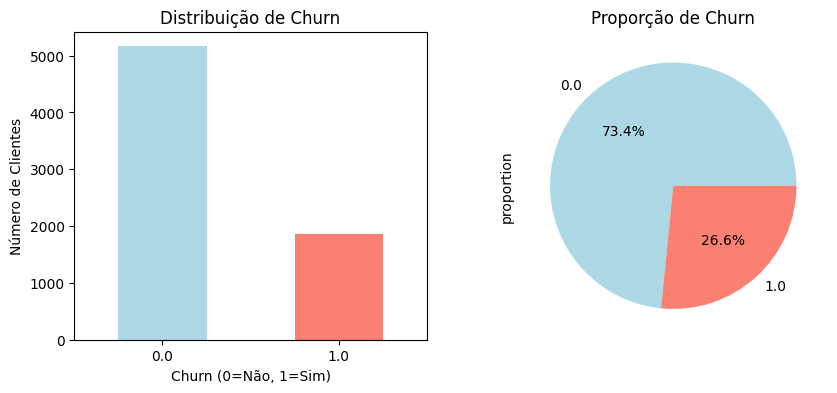

In [6]:
# Análise da distribuição de churn

# Contagem e proporções
churn_counts = df_encoded['Churn'].value_counts()
churn_props = df_encoded['Churn'].value_counts(normalize=True)

print("DISTRIBUIÇÃO DE CHURN")
print(f"Permaneceram (0): {churn_counts[0]:,} ({churn_props[0]:.1%})")
print(f"Evadiram (1): {churn_counts[1]:,} ({churn_props[1]:.1%})")
print(f"Total: {len(df_encoded):,}")

# Taxa de churn e desequilíbrio
taxa_churn = churn_props[1]
ratio = churn_counts[0] / churn_counts[1]

print(f"\nTaxa de Churn: {taxa_churn:.1%}")
print(f"Razão Permaneceram/Evadiram: {ratio:.1f}:1")

# Classificação do desequilíbrio
if ratio < 1.5:
    nivel = "EQUILIBRADO"
elif ratio < 3:
    nivel = "LEVEMENTE DESEQUILIBRADO"
elif ratio < 10:
    nivel = "MODERADAMENTE DESEQUILIBRADO" 
else:
    nivel = "SEVERAMENTE DESEQUILIBRADO"

print(f"Classificação: {nivel}")

# Recomendações
print("\nRECOMENDAÇÕES:")
if ratio < 3:
    print("- Dataset balanceado, modelos padrão funcionarão bem")
elif ratio < 10:
    print("- Considere SMOTE ou class_weight='balanced'")
    print("- Use métricas: F1-score, Precision, Recall")
else:
    print("- Balanceamento obrigatório (SMOTE + undersampling)")
    print("- Use métricas: AUC-ROC, F1-score, Balanced Accuracy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Gráfico de barras
churn_counts.plot(kind='bar', ax=ax1, color=['lightblue', 'salmon'])
ax1.set_title('Distribuição de Churn')
ax1.set_xlabel('Churn (0=Não, 1=Sim)')
ax1.set_ylabel('Número de Clientes')
ax1.tick_params(axis='x', rotation=0)

# Gráfico de pizza
churn_props.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=['lightblue', 'salmon'])
ax2.set_title('Proporção de Churn')

In [7]:
# Análise de balanceamento e recomendação

# Análise da distribuição atual
churn_counts = df_encoded['Churn'].value_counts()
churn_props = df_encoded['Churn'].value_counts(normalize=True)
ratio = churn_counts[0] / churn_counts[1]

print("ANÁLISE DE BALANCEAMENTO")
print(f"Permaneceram (0): {churn_counts[0]:,} ({churn_props[0]:.1%})")
print(f"Evadiram (1): {churn_counts[1]:,} ({churn_props[1]:.1%})")
print(f"Razão: {ratio:.1f}:1")

# Decisão sobre balanceamento
print("\nRECOMENDAÇÃO:")
if ratio < 3:
    print("BALANCEAMENTO NÃO NECESSÁRIO")
    print("Motivos:")
    print("- Ratio < 3:1 é considerado equilibrado")
    print("- Modelos padrão funcionam bem")
    print("- Evita complexidade desnecessária")
    print("- Dados originais são mais confiáveis")
    
elif ratio < 5:
    print("BALANCEAMENTO OPCIONAL")
    print("- Pode usar class_weight='balanced'")
    print("- Ou aplicar SMOTE se performance não for satisfatória")
    
else:
    print("BALANCEAMENTO RECOMENDADO")
    print("- Aplicar SMOTE ou SMOTEENN")
    print("- Usar métricas específicas (F1-score, AUC-ROC)")

print("\nUtilizarei o dataset atual (df_encoded) para modelagem")

ANÁLISE DE BALANCEAMENTO
Permaneceram (0): 5,163 (73.4%)
Evadiram (1): 1,869 (26.6%)
Razão: 2.8:1

RECOMENDAÇÃO:
BALANCEAMENTO NÃO NECESSÁRIO
Motivos:
- Ratio < 3:1 é considerado equilibrado
- Modelos padrão funcionam bem
- Evita complexidade desnecessária
- Dados originais são mais confiáveis

Utilizarei o dataset atual (df_encoded) para modelagem


In [8]:
# Verificação rápida da necessidade de normalização

# Separar variáveis numéricas (exceto target)
X = df_encoded.drop('Churn', axis=1)
numeric_cols = X.select_dtypes(include=[np.number]).columns

print("ESCALAS DAS VARIÁVEIS NUMÉRICAS:")
for col in numeric_cols:
    print(f"{col}: {X[col].min():.1f} a {X[col].max():.1f}")

# Verificar diferença de escala
ranges = [X[col].max() - X[col].min() for col in numeric_cols]
ratio_escala = max(ranges) / min(ranges) if min(ranges) > 0 else 1

print(f"\nRazão entre escalas: {ratio_escala:.1f}x")

# Resposta direta
if ratio_escala > 10:
    resposta = "SIM - OBRIGATÓRIA"
elif ratio_escala > 5:
    resposta = "SIM - RECOMENDADA"
else:
    resposta = "NÃO - OPCIONAL"

print(f"\nNormalização necessária? {resposta}")

ESCALAS DAS VARIÁVEIS NUMÉRICAS:
SeniorCitizen: 0.0 a 1.0
tenure: 1.0 a 72.0
Charges.Monthly: 18.2 a 118.8

Razão entre escalas: 100.5x

Normalização necessária? SIM - OBRIGATÓRIA


In [9]:
# Normalização simples dos dados

# Separar variáveis numéricas
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns.drop('Churn')

# Criar dataset normalizado
df_norm = df_encoded.copy()
scaler = StandardScaler()
df_norm[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

print(f"{len(numeric_cols)} variáveis numéricas normalizadas")
print(f"Dataset df_norm criado: {df_norm.shape}")

# Verificação rápida
print("\nExemplo de normalização:")
exemplo = numeric_cols[0]
print(f"{exemplo}: {df_encoded[exemplo].min():.1f}-{df_encoded[exemplo].max():.1f} → {df_norm[exemplo].min():.1f}-{df_norm[exemplo].max():.1f}")

3 variáveis numéricas normalizadas
Dataset df_norm criado: (7032, 28)

Exemplo de normalização:
SeniorCitizen: 0.0-1.0 → -0.4-2.3


In [10]:
# Verificação do processo de normalização

# Separar variáveis numéricas (exceto target)
X = df_norm.drop('Churn', axis=1)
numeric_cols = X.select_dtypes(include=[np.number]).columns

print("ESCALAS DAS VARIÁVEIS NUMÉRICAS:")
for col in numeric_cols:
    print(f"{col}: {X[col].min():.1f} a {X[col].max():.1f}")

# Verificar diferença de escala
ranges = [X[col].max() - X[col].min() for col in numeric_cols]
ratio_escala = max(ranges) / min(ranges) if min(ranges) > 0 else 1

print(f"\nRazão entre escalas: {ratio_escala:.1f}x")

# Resposta direta
if ratio_escala > 10:
    resposta = "SIM - OBRIGATÓRIA"
elif ratio_escala > 5:
    resposta = "SIM - RECOMENDADA"
else:
    resposta = "NÃO - OPCIONAL"

print(f"\nNormalização necessária? {resposta}")

ESCALAS DAS VARIÁVEIS NUMÉRICAS:
SeniorCitizen: -0.4 a 2.3
tenure: -1.3 a 1.6
Charges.Monthly: -1.5 a 1.8

Razão entre escalas: 1.2x

Normalização necessária? NÃO - OPCIONAL


### Correlação e Seleção de Variáveis

In [11]:
# Seleção de variáveis para modelagem baseada em correlação

# Calcular matriz de correlação
correlation_matrix = df_encoded.corr()

# Analisar correlação com Churn especificamente
churn_correlations = correlation_matrix['Churn'].abs().sort_values(ascending=False)

print("ANÁLISE DE CORRELAÇÃO COM CHURN:")
print("=" * 50)

# Categorizar variáveis por força da correlação
alta_correlacao = []
media_correlacao = []
baixa_correlacao = []

for var, corr in churn_correlations.items():
    if var != 'Churn':
        if corr >= 0.2:
            alta_correlacao.append((var, corr))
        elif corr >= 0.1:
            media_correlacao.append((var, corr))
        else:
            baixa_correlacao.append((var, corr))

print("VARIÁVEIS DE ALTA IMPORTÂNCIA (correlação ≥ 0.2):")
print("Essas são os MELHORES preditores de churn:")
for var, corr in alta_correlacao:
    print(f"- {var}: {corr:.3f}")

print("\nVARIÁVEIS DE MÉDIA IMPORTÂNCIA (correlação 0.1-0.2):")
print("Podem ser incluídas para melhorar o modelo:")
for var, corr in media_correlacao:
    print(f"- {var}: {corr:.3f}")

print("\nVARIÁVEIS DE BAIXA IMPORTÂNCIA (correlação < 0.1):")
print("Podem ser removidas sem prejudicar a performance:")
print(f"Total: {len(baixa_correlacao)} variáveis")

# Recomendação final
variaveis_recomendadas = [var for var, corr in alta_correlacao + media_correlacao]

print("\n" + "="*60)
print("RECOMENDAÇÃO FINAL PARA MODELAGEM:")
print("="*60)
print(f"USAR {len(variaveis_recomendadas)} variáveis principais:")
print()

for i, (var, corr) in enumerate(alta_correlacao + media_correlacao, 1):
    importancia = "ALTA" if corr >= 0.2 else "MÉDIA"
    print(f"{i:2d}. {var} (correlação: {corr:.3f}) - {importancia}")

print("\nJUSTIFICATIVA:")
print("- Variáveis com correlação ≥ 0.1 têm poder preditivo significativo")
print("- Reduz dimensionalidade mantendo informação relevante")
print("- Melhora performance e interpretabilidade do modelo")
print("- Evita overfitting por excesso de variáveis irrelevantes")

# Preparar dataset otimizado
X_otimizado = df_encoded[variaveis_recomendadas]
y = df_encoded['Churn']

print("\nDATASET OTIMIZADO PREPARADO:")
print(f"X_otimizado: {X_otimizado.shape}")
print(f"y: {y.shape}")
print(f"Redução: {len(df_encoded.columns)-1} → {len(variaveis_recomendadas)} variáveis")

ANÁLISE DE CORRELAÇÃO COM CHURN:
VARIÁVEIS DE ALTA IMPORTÂNCIA (correlação ≥ 0.2):
Essas são os MELHORES preditores de churn:
- tenure: 0.354
- InternetService_Fiber optic: 0.307
- Contract_Two year: 0.302
- PaymentMethod_Electronic check: 0.301
- TechSupport_No internet service: 0.228
- OnlineSecurity_No internet service: 0.228
- StreamingTV_No internet service: 0.228
- DeviceProtection_No internet service: 0.228
- OnlineBackup_No internet service: 0.228
- StreamingMovies_No internet service: 0.228
- InternetService_No: 0.228

VARIÁVEIS DE MÉDIA IMPORTÂNCIA (correlação 0.1-0.2):
Podem ser incluídas para melhorar o modelo:
- Charges.Monthly: 0.193
- PaperlessBilling_Yes: 0.191
- Contract_One year: 0.178
- OnlineSecurity_Yes: 0.171
- TechSupport_Yes: 0.165
- Dependents_Yes: 0.163
- SeniorCitizen: 0.151
- Partner_Yes: 0.150
- PaymentMethod_Credit card (automatic): 0.135

VARIÁVEIS DE BAIXA IMPORTÂNCIA (correlação < 0.1):
Podem ser removidas sem prejudicar a performance:
Total: 7 variávei

In [12]:
# Análise 1: Tempo de contrato (tenure) vs Churn

print("ANÁLISE: TEMPO DE CONTRATO × EVASÃO")
print("=" * 40)

# Estatísticas por grupo
media_permaneceu = df_encoded[df_encoded['Churn']==0]['tenure'].mean()
media_evadiu = df_encoded[df_encoded['Churn']==1]['tenure'].mean()

print(f"Tenure médio:")
print(f"Permaneceram: {media_permaneceu:.1f} meses")
print(f"Evadiram: {media_evadiu:.1f} meses")
print(f"Diferença: {media_permaneceu - media_evadiu:.1f} meses")

if media_evadiu < media_permaneceu:
    print("\n- Clientes com MENOR tempo tendem a evadir mais")
    print("- Período crítico: primeiros meses de contrato")
else:
    print("\n- Clientes com MAIOR tempo tendem a evadir mais")

ANÁLISE: TEMPO DE CONTRATO × EVASÃO
Tenure médio:
Permaneceram: 37.7 meses
Evadiram: 18.0 meses
Diferença: 19.7 meses

- Clientes com MENOR tempo tendem a evadir mais
- Período crítico: primeiros meses de contrato


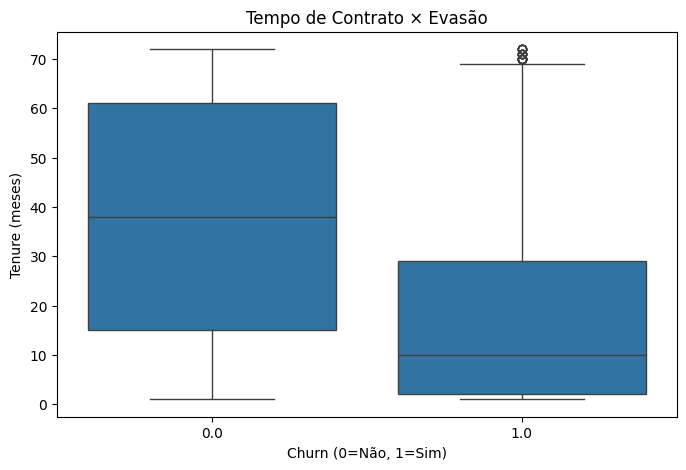

In [13]:
# Gráfico 1: Boxplot Tenure vs Churn

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_encoded, x='Churn', y='tenure')
plt.title('Tempo de Contrato × Evasão')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Tenure (meses)')
plt.show()

In [14]:
# Análise 2: Gastos mensais vs Churn

print("ANÁLISE: GASTOS MENSAIS × EVASÃO")
print("=" * 35)

# Estatísticas por grupo
media_gastos_permaneceu = df_encoded[df_encoded['Churn']==0]['Charges.Monthly'].mean()
media_gastos_evadiu = df_encoded[df_encoded['Churn']==1]['Charges.Monthly'].mean()

print("Gastos mensais médios:")
print(f"Permaneceram: R$ {media_gastos_permaneceu:.2f}")
print(f"Evadiram: R$ {media_gastos_evadiu:.2f}")
print(f"Diferença: R$ {media_gastos_evadiu - media_gastos_permaneceu:.2f}")

if media_gastos_evadiu > media_gastos_permaneceu:
    print("\n- Clientes que gastam MAIS tendem a evadir mais")
    print("- Possível insatisfação com custo-benefício")
else:
    print("\n- Clientes que gastam MENOS tendem a evadir mais")

ANÁLISE: GASTOS MENSAIS × EVASÃO
Gastos mensais médios:
Permaneceram: R$ 61.31
Evadiram: R$ 74.44
Diferença: R$ 13.13

- Clientes que gastam MAIS tendem a evadir mais
- Possível insatisfação com custo-benefício


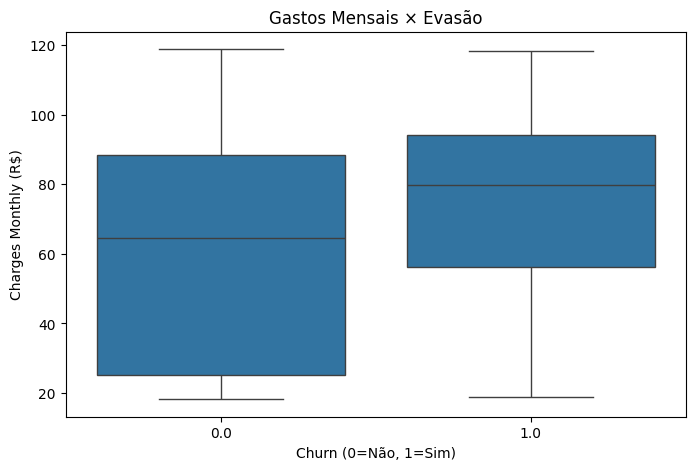

In [15]:
# Gráfico 2: Boxplot Gastos Mensais vs Churn

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_encoded, x='Churn', y='Charges.Monthly')
plt.title('Gastos Mensais × Evasão')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Charges Monthly (R$)')
plt.show()

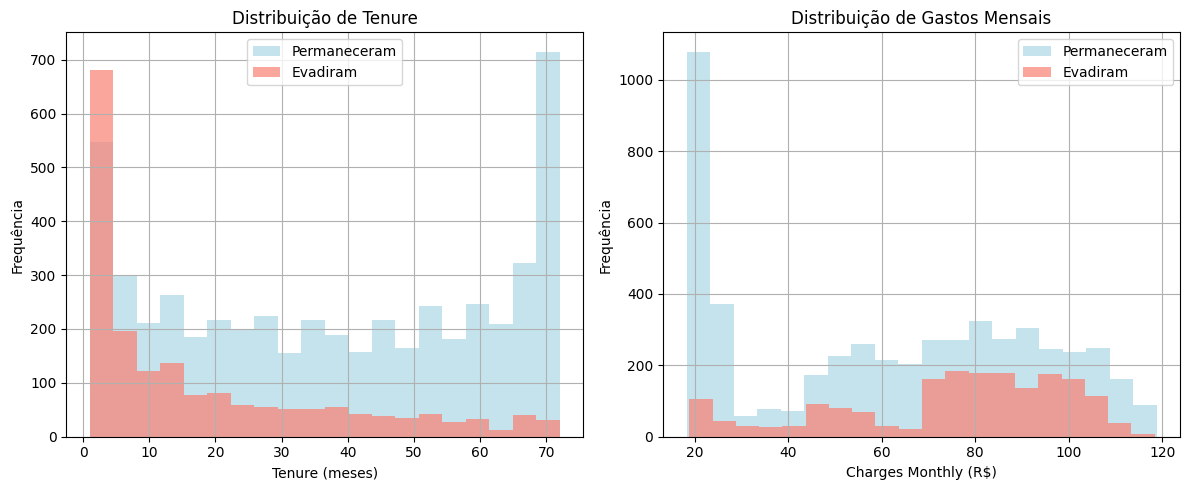

In [16]:
# Gráfico 3: Histogramas comparativos

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histograma Tenure
df_encoded[df_encoded['Churn']==0]['tenure'].hist(alpha=0.7, label='Permaneceram', 
                                                  bins=20, ax=ax1, color='lightblue')
df_encoded[df_encoded['Churn']==1]['tenure'].hist(alpha=0.7, label='Evadiram', 
                                                  bins=20, ax=ax1, color='salmon')
ax1.set_title('Distribuição de Tenure')
ax1.set_xlabel('Tenure (meses)')
ax1.set_ylabel('Frequência')
ax1.legend()

# Histograma Gastos
df_encoded[df_encoded['Churn']==0]['Charges.Monthly'].hist(alpha=0.7, label='Permaneceram', 
                                                          bins=20, ax=ax2, color='lightblue')
df_encoded[df_encoded['Churn']==1]['Charges.Monthly'].hist(alpha=0.7, label='Evadiram', 
                                                          bins=20, ax=ax2, color='salmon')
ax2.set_title('Distribuição de Gastos Mensais')
ax2.set_xlabel('Charges Monthly (R$)')
ax2.set_ylabel('Frequência')
ax2.legend()

plt.tight_layout()
plt.show()

In [17]:
# Resumo dos Insights

print("PRINCIPAIS INSIGHTS:")
print("=" * 25)

# Recalcular para o resumo
media_tenure_perm = df_encoded[df_encoded['Churn']==0]['tenure'].mean()
media_tenure_evad = df_encoded[df_encoded['Churn']==1]['tenure'].mean()
media_gastos_perm = df_encoded[df_encoded['Churn']==0]['Charges.Monthly'].mean()
media_gastos_evad = df_encoded[df_encoded['Churn']==1]['Charges.Monthly'].mean()

print("1. TENURE (Tempo de contrato):")
if media_tenure_evad < media_tenure_perm:
    print("   - Clientes NOVOS têm maior risco de churn")
    print(f"   - Período crítico: primeiros {media_tenure_evad:.0f} meses")
else:
    print("   - Clientes ANTIGOS têm maior risco de churn")

print("\n2. GASTOS MENSAIS:")
if media_gastos_evad > media_gastos_perm:
    print("   - Clientes com MAIORES gastos têm maior risco")
    print("   - Possível insatisfação com custo-benefício")
else:
    print("   - Clientes com MENORES gastos têm maior risco")

PRINCIPAIS INSIGHTS:
1. TENURE (Tempo de contrato):
   - Clientes NOVOS têm maior risco de churn
   - Período crítico: primeiros 18 meses

2. GASTOS MENSAIS:
   - Clientes com MAIORES gastos têm maior risco
   - Possível insatisfação com custo-benefício


### Criação dos Modelos Preditivos

**O que vamos fazer agora?**
Vamos criar 2 modelos diferentes para prever se um cliente vai cancelar o serviço (churn):

**Plano de Ação:**
1. **Modelo 1: Random Forest** 
   - Funciona bem sem normalizar os dados
   - Fácil de interpretar
   - Boa performance na maioria dos casos

2. **Modelo 2: Regressão Logística**
   - Precisa normalizar os dados
   - Muito interpretável (mostra probabilidades)
   - Rápido e eficiente

**Objetivo:** Comparar qual modelo funciona melhor com nossos dados!

In [18]:
# PREPARANDO OS DADOS PARA OS MODELOS

print("PREPARAÇÃO DOS DADOS")
print("=" * 30)

print("Por que preparar os dados?")
print("   • Modelo 1 (Random Forest): Não precisa normalizar")
print("   • Modelo 2 (Regressão Logística): Precisa normalizar")
print("   • Vamos usar as mesmas variáveis importantes para comparar\n")

# DATASET 1: Para Random Forest (dados originais)
X1 = df_encoded[variaveis_recomendadas]  # Variáveis importantes
y1 = df_encoded['Churn']                 # O que queremos prever

# Dividir em treino e teste
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.3, random_state=22
)

print("DATASET 1 (Random Forest):")
print(f"   • Variáveis: {len(variaveis_recomendadas)}")
print(f"   • Dados de treino: {X1_train.shape[0]:,} clientes")
print(f"   • Dados de teste: {X1_test.shape[0]:,} clientes")
print("   • Normalização: NÃO (Random Forest não precisa)\n")

print("Dados prontos para o Random Forest!")

PREPARAÇÃO DOS DADOS
Por que preparar os dados?
   • Modelo 1 (Random Forest): Não precisa normalizar
   • Modelo 2 (Regressão Logística): Precisa normalizar
   • Vamos usar as mesmas variáveis importantes para comparar

DATASET 1 (Random Forest):
   • Variáveis: 20
   • Dados de treino: 4,922 clientes
   • Dados de teste: 2,110 clientes
   • Normalização: NÃO (Random Forest não precisa)

Dados prontos para o Random Forest!


In [19]:
# PREPARANDO DADOS PARA REGRESSÃO LOGÍSTICA

print("PREPARAÇÃO DATASET 2 (NORMALIZADO)")  
print("=" * 40)

print("Por que normalizar?")
print("   • Regressão Logística é sensível a diferentes escalas")
print("   • Exemplo: idade (0-100) vs renda (0-10000)")
print("   • Normalização deixa tudo na mesma escala (-2 a +2)\n")

# DATASET 2: Para Regressão Logística (dados normalizados)
X2 = df_norm[variaveis_recomendadas]  # Mesmas variáveis, mas normalizadas
y2 = df_norm['Churn']                 # Target é o mesmo

# Dividir em treino e teste (mesmo split para comparar)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.3, random_state=22
)

print("DATASET 2 (Regressão Logística):")
print(f"   • Variáveis: {len(variaveis_recomendadas)} (as mesmas)")
print(f"   • Dados de treino: {X2_train.shape[0]:,} clientes")
print(f"   • Dados de teste: {X2_test.shape[0]:,} clientes") 
print("   • Normalização: SIM (valores entre -2 e +2)")

# Mostrar exemplo da normalização
print("\nExemplo de normalização:")
variavel_exemplo = variaveis_recomendadas[0]
print(f"   • {variavel_exemplo}:")
print(f"     Antes: {df_encoded[variavel_exemplo].min():.1f} a {df_encoded[variavel_exemplo].max():.1f}")
print(f"     Depois: {X2[variavel_exemplo].min():.1f} a {X2[variavel_exemplo].max():.1f}")

print("\nDados normalizados prontos para Regressão Logística!")

PREPARAÇÃO DATASET 2 (NORMALIZADO)
Por que normalizar?
   • Regressão Logística é sensível a diferentes escalas
   • Exemplo: idade (0-100) vs renda (0-10000)
   • Normalização deixa tudo na mesma escala (-2 a +2)

DATASET 2 (Regressão Logística):
   • Variáveis: 20 (as mesmas)
   • Dados de treino: 4,922 clientes
   • Dados de teste: 2,110 clientes
   • Normalização: SIM (valores entre -2 e +2)

Exemplo de normalização:
   • tenure:
     Antes: 1.0 a 72.0
     Depois: -1.3 a 1.6

Dados normalizados prontos para Regressão Logística!


#### Modelo 1: Random Forest 

**O que é Random Forest?**
- É um algoritmo que cria várias "árvores de decisão" e usa a "votação" entre elas
- Funciona bem com dados de diferentes escalas (não precisa normalizar)
- É robusto contra overfitting (não "decora" demais os dados de treino)

**Por que escolhemos este modelo?**
- Simples de usar e interpretar
- Boa performance na maioria dos casos
- Não precisa de pré-processamento complexo
- Mostra quais variáveis são mais importantes

In [20]:
# PASSO 1: Criar o modelo Random Forest

print("CRIANDO MODELO RANDOM FOREST")
print("=" * 35)

# Criar o modelo com parâmetros simples e explicados
rf_model = RandomForestClassifier(
    n_estimators=100,        # Quantas árvores criar (mais = melhor, mas mais lento)
    random_state=42,         # Para sempre ter o mesmo resultado
    max_depth=10,            # Profundidade máxima de cada árvore (evita overfitting)
    class_weight='balanced', # Balancear automaticamente as classes (Churn vs Não-Churn)
    min_samples_leaf=5,      # Número mínimo de amostras em cada folha
    max_features='sqrt'      # Número de variáveis consideradas em cada divisão ('sqrt' é padrão moderno)
)

# PASSO 2: Treinar o modelo
print("Treinando o modelo...")
rf_model.fit(X1_train, y1_train)

print("Modelo treinado com sucesso!")
print(f"   • Usamos {rf_model.n_estimators} árvores")
print(f"   • Dados de treino: {X1_train.shape[0]} clientes")
print(f"   • Variáveis: {X1_train.shape[1]} características")

CRIANDO MODELO RANDOM FOREST
Treinando o modelo...


Modelo treinado com sucesso!
   • Usamos 100 árvores
   • Dados de treino: 4922 clientes
   • Variáveis: 20 características


In [21]:
# PASSO 4: Verificar se o modelo é confiável (Validação Cruzada)

print("TESTANDO A CONFIABILIDADE DO MODELO")
print("=" * 45)

# Fazer 5 testes diferentes
cv_scores = cross_val_score(rf_model, X1_train, y1_train, cv=5, scoring='accuracy')

print("Resultados dos 5 testes:")
for i, score in enumerate(cv_scores, 1):
    print(f"   Teste {i}: {score:.1%}")

# Calcular estatísticas
media = cv_scores.mean()
desvio = cv_scores.std()

print("\nResumo:")
print(f"   Média: {media:.1%}")
print(f"   Variação: ±{desvio:.1%}")

# Avaliar se é confiável
if desvio < 0.02:
    print("   MODELO CONFIÁVEL! (baixa variação)")
elif desvio < 0.05:
    print("   Modelo razoavelmente confiável")
else:
    print("   Modelo instável (muita variação)")

print(f"\nPerformance esperada em produção: {media:.1%}")

TESTANDO A CONFIABILIDADE DO MODELO
Resultados dos 5 testes:
   Teste 1: 77.0%
   Teste 2: 75.1%
   Teste 3: 77.3%
   Teste 4: 75.4%
   Teste 5: 76.3%

Resumo:
   Média: 76.2%
   Variação: ±0.9%
   MODELO CONFIÁVEL! (baixa variação)

Performance esperada em produção: 76.2%


In [22]:
# PASSO 5: Tentar melhorar o modelo (Otimização Simples)

print("MELHORANDO O MODELO")
print("=" * 25)

# Configurações para testar (versão simplificada)
configuracoes = {
    'n_estimators': [50, 100, 200],      # Quantas árvores usar
    'max_depth': [5, 10, 15],            # Quão profundas as árvores podem ser
    'min_samples_split': [2, 4, 6],      # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [5, 10, 20]      # Mínimo de amostras em cada "folha" 
}

print("Vamos testar:")
print(f"   • {len(configuracoes['n_estimators'])} opções de número de árvores")
print(f"   • {len(configuracoes['max_depth'])} opções de profundidade")
print(f"   • {len(configuracoes['min_samples_split'])} opções de mínimo para dividir")
print(f"   • {len(configuracoes['min_samples_leaf'])} opções de tamanho mínimo")

total_testes = 3
for opcoes in configuracoes.values():
    total_testes *= len(opcoes)
print(f"   = {total_testes} combinações no total")

# Criar o testador automático
testador = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=configuracoes,
    cv=3,              # 3 testes para cada configuração
    scoring='accuracy', # Queremos maximizar a acurácia
    n_jobs=-1          # Usar toda a capacidade do computador
)

print("\nIniciando os testes...")
start_time = time.time()

# Executar todos os testes
testador.fit(X1_train, y1_train)

tempo_total = time.time() - start_time
print(f"Testes concluídos em {tempo_total:.1f} segundos")

MELHORANDO O MODELO
Vamos testar:
   • 3 opções de número de árvores
   • 3 opções de profundidade
   • 3 opções de mínimo para dividir
   • 3 opções de tamanho mínimo
   = 243 combinações no total

Iniciando os testes...
Testes concluídos em 32.7 segundos


In [23]:
# PASSO 6: Ver qual configuração foi a melhor

print("RESULTADOS DA OTIMIZAÇÃO")
print("=" * 35)

# Mostrar a melhor configuração encontrada
print("Melhor configuração encontrada:")
for parametro, valor in testador.best_params_.items():
    print(f"   • {parametro}: {valor}")

melhor_score = testador.best_score_
score_original = cv_scores.mean()

print("\nCOMPARAÇÃO DE PERFORMANCE:")
print(f"   Modelo original: {score_original:.1%}")
print(f"   Modelo melhorado: {melhor_score:.1%}")

# Calcular melhoria
melhoria = melhor_score - score_original
if melhoria > 0:
    print(f"   Melhoramos {melhoria:.1%}! ({melhoria/score_original*100:+.1f}%)")
elif melhoria == 0:
    print("   Ficou igual (o modelo original já estava bom)")
else:
    print(f"   Ficou {abs(melhoria):.1%} pior (às vezes isso acontece)")

RESULTADOS DA OTIMIZAÇÃO
Melhor configuração encontrada:
   • max_depth: 15
   • min_samples_leaf: 5
   • min_samples_split: 2
   • n_estimators: 200

COMPARAÇÃO DE PERFORMANCE:
   Modelo original: 76.2%
   Modelo melhorado: 77.0%
   Melhoramos 0.8%! (+1.1%)


In [24]:
# PASSO 7: Testar o modelo melhorado nos dados finais

print("TESTANDO O MODELO MELHORADO")
print("=" * 35)

# Pegar o melhor modelo que foi encontrado
modelo_melhorado = testador.best_estimator_

# Primeiro, vamos calcular a acurácia do modelo original para comparação
y1_pred = rf_model.predict(X1_test)
rf_accuracy = accuracy_score(y1_test, y1_pred)

# Testar nos dados que ele nunca viu antes
print("Testando em dados completamente novos...")
predicoes_melhoradas = modelo_melhorado.predict(X1_test)

# Calcular a performance final
acuracia_melhorada = accuracy_score(y1_test, predicoes_melhoradas)

print("\nRESULTADOS FINAIS:")
print(f"   Modelo original: {rf_accuracy:.1%}")
print(f"   Modelo melhorado: {acuracia_melhorada:.1%}")

melhoria_final = acuracia_melhorada - rf_accuracy
if melhoria_final > 0:
    print(f"   Melhoramos {melhoria_final:.1%} pontos!")
elif melhoria_final == 0:
    print("   Mantivemos a mesma performance")
else:
    print(f"   Performance ficou {abs(melhoria_final):.1%} menor")

# Relatório final
print("\nRelatório Final do Modelo Melhorado:")
print(classification_report(y1_test, predicoes_melhoradas, target_names=['Não vai sair', 'Vai sair']))

# Salvar o modelo final para usar depois
modelo_final = modelo_melhorado
acuracia_final = acuracia_melhorada

print(f"Performance final: {acuracia_final:.1%}")

TESTANDO O MODELO MELHORADO
Testando em dados completamente novos...

RESULTADOS FINAIS:
   Modelo original: 77.8%
   Modelo melhorado: 78.4%
   Melhoramos 0.6% pontos!

Relatório Final do Modelo Melhorado:
              precision    recall  f1-score   support

Não vai sair       0.89      0.80      0.85      1555
    Vai sair       0.57      0.74      0.64       555

    accuracy                           0.78      2110
   macro avg       0.73      0.77      0.74      2110
weighted avg       0.81      0.78      0.79      2110

Performance final: 78.4%


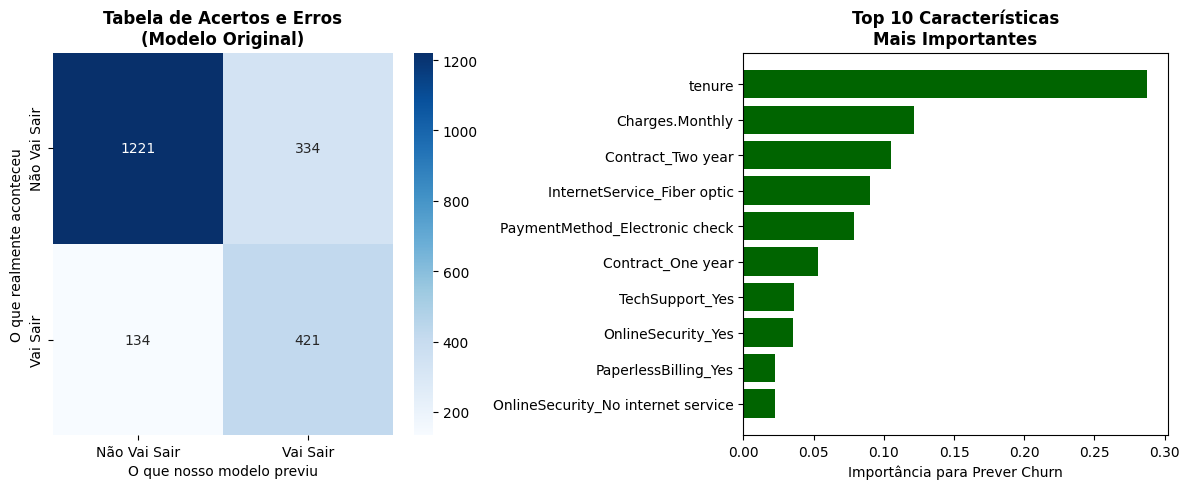

In [25]:
# PASSO 8: Gráficos Básicos do Random Forest

# Criar 2 gráficos simples
plt.figure(figsize=(12, 5))

# 1. Matriz de Confusão Simples
plt.subplot(1, 2, 1)
cm_simples = confusion_matrix(y1_test, y1_pred)
sns.heatmap(cm_simples, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Vai Sair', 'Vai Sair'],
            yticklabels=['Não Vai Sair', 'Vai Sair'])
plt.title('Tabela de Acertos e Erros\n(Modelo Original)', fontweight='bold')
plt.ylabel('O que realmente aconteceu')
plt.xlabel('O que nosso modelo previu')

# 2. Top 10 Variáveis Mais Importantes
plt.subplot(1, 2, 2)
importancia_simples = pd.DataFrame({
    'variavel': X1_train.columns,
    'importancia': rf_model.feature_importances_
}).sort_values('importancia', ascending=True)

# Pegar as 10 mais importantes
top_10_simples = importancia_simples.tail(10)
plt.barh(range(len(top_10_simples)), top_10_simples['importancia'], color='darkgreen')
plt.yticks(range(len(top_10_simples)), top_10_simples['variavel'])
plt.title('Top 10 Características\nMais Importantes', fontweight='bold')
plt.xlabel('Importância para Prever Churn')

plt.tight_layout()
plt.show()

#### Modelo 2: Regressão Logística (Dataset Normalizado)

**Justificativa da escolha:**
- **Exige normalização**: Sensível a diferentes escalas de dados
- **Interpretável**: Coeficientes têm significado claro (odds ratio)
- **Probabilístico**: Fornece probabilidades de predição
- **Eficiente**: Rápido treinamento e predição
- **Baseline forte**: Excelente para comparação com modelos complexos
- **Regularização**: Controle de overfitting com L1/L2

**Por que usar dados normalizados:**
- Algoritmos baseados em distância (como Regressão Logística) são sensíveis à escala
- Evita que variáveis com valores maiores dominem o modelo
- Melhora convergência do algoritmo de otimização

In [26]:
# Criação e Treinamento da Regressão Logística

print("TREINANDO REGRESSÃO LOGÍSTICA")
print("=" * 40)

# Criar o modelo com regularização
lr_model = LogisticRegression(
    random_state=42,         # Reprodutibilidade
    max_iter=1000,          # Garantir convergência
    class_weight='balanced', # Balancear classes
    C=1.0                   # Regularização (menor = mais regularização)
)

# Treinar o modelo com dados normalizados
lr_model.fit(X2_train, y2_train)

print("Modelo Regressão Logística treinado com sucesso!")
print(f"Dados normalizados utilizados: {X2_train.shape}")
print(f"Convergência alcançada em {lr_model.n_iter_[0]} iterações")

TREINANDO REGRESSÃO LOGÍSTICA
Modelo Regressão Logística treinado com sucesso!
Dados normalizados utilizados: (4922, 20)
Convergência alcançada em 17 iterações


In [27]:
# PASSO 4: Verificar se o modelo é confiável (Validação Cruzada)

print("TESTANDO A CONFIABILIDADE DA REGRESSÃO LOGÍSTICA")
print("=" * 55)

# Fazer 5 testes diferentes
cv_scores_lr = cross_val_score(lr_model, X2_train, y2_train, cv=5, scoring='accuracy')

print("Resultados dos 5 testes:")
for i, score in enumerate(cv_scores_lr, 1):
    print(f"   Teste {i}: {score:.1%}")

# Calcular estatísticas
media_lr = cv_scores_lr.mean()
desvio_lr = cv_scores_lr.std()

print("\nResumo:")
print(f"   Média: {media_lr:.1%}")
print(f"   Variação: ±{desvio_lr:.1%}")

# Avaliar se é confiável
if desvio_lr < 0.02:
    print("   MODELO CONFIÁVEL! (baixa variação)")
elif desvio_lr < 0.05:
    print("   Modelo razoavelmente confiável")
else:
    print("   Modelo instável (muita variação)")

print(f"\nPerformance esperada em produção: {media_lr:.1%}")

TESTANDO A CONFIABILIDADE DA REGRESSÃO LOGÍSTICA
Resultados dos 5 testes:
   Teste 1: 74.6%
   Teste 2: 75.0%
   Teste 3: 75.2%
   Teste 4: 73.9%
   Teste 5: 74.7%

Resumo:
   Média: 74.7%
   Variação: ±0.5%
   MODELO CONFIÁVEL! (baixa variação)

Performance esperada em produção: 74.7%


In [28]:
# PASSO 5: Tentar melhorar o modelo (Otimização Simples)

print("MELHORANDO A REGRESSÃO LOGÍSTICA")
print("=" * 40)

# Configurações para testar (versão simplificada)
configuracoes_lr = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],     # Força da regularização (menor C = mais regularização)
    'penalty': ['l1', 'l2'],                  # Tipo de regularização
    'solver': ['liblinear', 'saga'],          # Algoritmo de otimização
    'max_iter': [1000, 2000]                  # Máximo de iterações
}

print("Vamos testar:")
print(f"   • {len(configuracoes_lr['C'])} opções de regularização")
print(f"   • {len(configuracoes_lr['penalty'])} tipos de penalização")
print(f"   • {len(configuracoes_lr['solver'])} algoritmos de otimização")
print(f"   • {len(configuracoes_lr['max_iter'])} limites de iteração")

total_testes_lr = 1
for opcoes in configuracoes_lr.values():
    total_testes_lr *= len(opcoes)
print(f"   = {total_testes_lr} combinações no total")

# Criar o testador automático
testador_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42, class_weight='balanced'),
    param_grid=configuracoes_lr,
    cv=3,              # 3 testes para cada configuração
    scoring='accuracy', # Queremos maximizar a acurácia
    n_jobs=-1          # Usar toda a capacidade do computador
)

print("\nIniciando os testes...")
start_time_lr = time.time()

# Executar todos os testes
testador_lr.fit(X2_train, y2_train)

tempo_total_lr = time.time() - start_time_lr
print(f"Testes concluídos em {tempo_total_lr:.1f} segundos")

MELHORANDO A REGRESSÃO LOGÍSTICA
Vamos testar:
   • 5 opções de regularização
   • 2 tipos de penalização
   • 2 algoritmos de otimização
   • 2 limites de iteração
   = 40 combinações no total

Iniciando os testes...
Testes concluídos em 1.4 segundos


In [29]:
# PASSO 6: Ver qual configuração foi a melhor

print("RESULTADOS DA OTIMIZAÇÃO - REGRESSÃO LOGÍSTICA")
print("=" * 50)

# Mostrar a melhor configuração encontrada
print("Melhor configuração encontrada:")
for parametro, valor in testador_lr.best_params_.items():
    print(f"   • {parametro}: {valor}")

melhor_score_lr = testador_lr.best_score_
score_original_lr = media_lr

print("\nCOMPARAÇÃO DE PERFORMANCE:")
print(f"   Modelo original: {score_original_lr:.1%}")
print(f"   Modelo melhorado: {melhor_score_lr:.1%}")

# Calcular melhoria
melhoria_lr = melhor_score_lr - score_original_lr
if melhoria_lr > 0:
    print(f"   Melhoramos {melhoria_lr:.1%}! ({melhoria_lr/score_original_lr*100:+.1f}%)")
elif melhoria_lr == 0:
    print("   Ficou igual (o modelo original já estava bom)")
else:
    print(f"   Ficou {abs(melhoria_lr):.1%} pior (às vezes isso acontece)")

RESULTADOS DA OTIMIZAÇÃO - REGRESSÃO LOGÍSTICA
Melhor configuração encontrada:
   • C: 0.1
   • max_iter: 1000
   • penalty: l1
   • solver: saga

COMPARAÇÃO DE PERFORMANCE:
   Modelo original: 74.7%
   Modelo melhorado: 75.0%
   Melhoramos 0.3%! (+0.4%)


In [30]:
# PASSO 7: Testar o modelo melhorado nos dados finais

print("TESTANDO A REGRESSÃO LOGÍSTICA MELHORADA")
print("=" * 45)

# Primeiro, calcular as métricas do modelo original para comparação
y2_pred_original = lr_model.predict(X2_test)
y2_pred_proba_original = lr_model.predict_proba(X2_test)[:, 1]
lr_accuracy = accuracy_score(y2_test, y2_pred_original)
lr_auc = roc_auc_score(y2_test, y2_pred_proba_original)

# Pegar o melhor modelo que foi encontrado
modelo_melhorado_lr = testador_lr.best_estimator_

# Testar nos dados que ele nunca viu antes
print("Testando em dados completamente novos...")
predicoes_melhoradas_lr = modelo_melhorado_lr.predict(X2_test)
predicoes_proba_melhoradas_lr = modelo_melhorado_lr.predict_proba(X2_test)[:, 1]

# Calcular a performance final
acuracia_melhorada_lr = accuracy_score(y2_test, predicoes_melhoradas_lr)
auc_melhorado_lr = roc_auc_score(y2_test, predicoes_proba_melhoradas_lr)

print("\nRESULTADOS FINAIS:")
print(f"   Modelo original: {lr_accuracy:.1%}")
print(f"   Modelo melhorado: {acuracia_melhorada_lr:.1%}")

melhoria_final_lr = acuracia_melhorada_lr - lr_accuracy
if melhoria_final_lr > 0:
    print(f"   Melhoramos {melhoria_final_lr:.1%} pontos!")
elif melhoria_final_lr == 0:
    print("   Mantivemos a mesma performance")
else:
    print(f"   Performance ficou {abs(melhoria_final_lr):.1%} menor")

print("\nMÉTRICAS ADICIONAIS:")
print(f"   AUC-ROC original: {lr_auc:.3f}")
print(f"   AUC-ROC melhorado: {auc_melhorado_lr:.3f}")

# Relatório final
print("\nRelatório Final da Regressão Logística Melhorada:")
print(classification_report(y2_test, predicoes_melhoradas_lr, target_names=['Não vai sair', 'Vai sair']))

# Salvar o modelo final para usar depois
modelo_final_lr = modelo_melhorado_lr
acuracia_final_lr = acuracia_melhorada_lr

print(f"Performance final: {acuracia_final_lr:.1%}")

TESTANDO A REGRESSÃO LOGÍSTICA MELHORADA
Testando em dados completamente novos...

RESULTADOS FINAIS:
   Modelo original: 75.2%
   Modelo melhorado: 75.4%
   Melhoramos 0.2% pontos!

MÉTRICAS ADICIONAIS:
   AUC-ROC original: 0.837
   AUC-ROC melhorado: 0.836

Relatório Final da Regressão Logística Melhorada:
              precision    recall  f1-score   support

Não vai sair       0.90      0.74      0.82      1555
    Vai sair       0.52      0.78      0.63       555

    accuracy                           0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.75      0.77      2110

Performance final: 75.4%


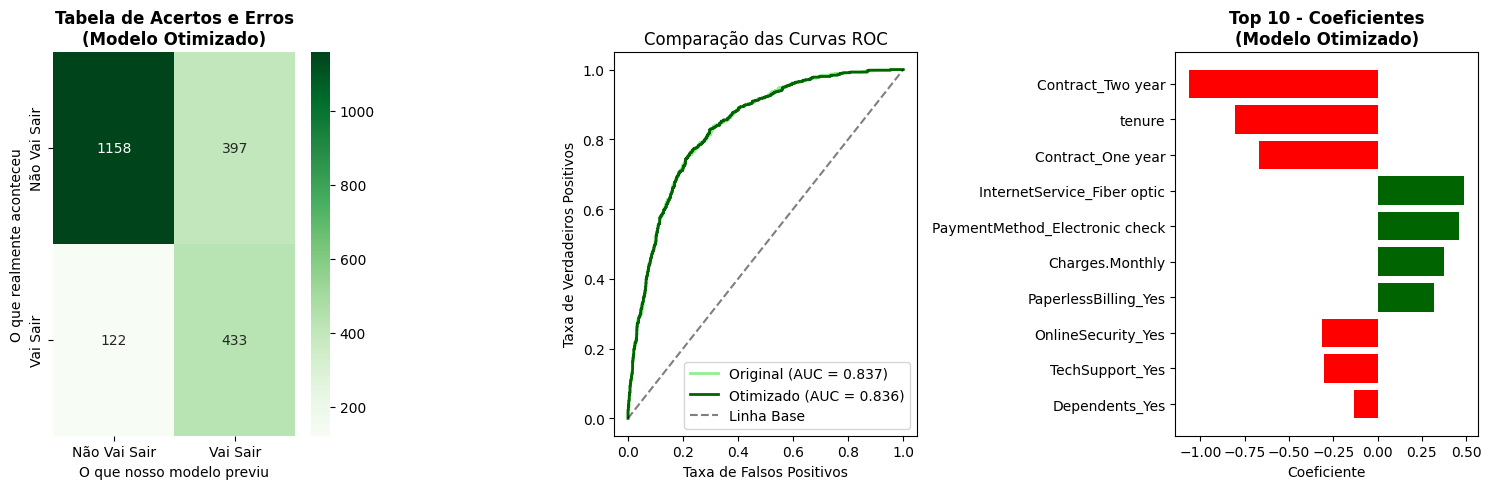

In [31]:
# PASSO 8: Gráficos da Regressão Logística Otimizada

# Criar 3 gráficos comparativos
plt.figure(figsize=(15, 5))

# 1. Matriz de Confusão do Modelo Melhorado
plt.subplot(1, 3, 1)
cm_melhorado_lr = confusion_matrix(y2_test, predicoes_melhoradas_lr)
sns.heatmap(cm_melhorado_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Não Vai Sair', 'Vai Sair'],
            yticklabels=['Não Vai Sair', 'Vai Sair'])
plt.title('Tabela de Acertos e Erros\n(Modelo Otimizado)', fontweight='bold')
plt.ylabel('O que realmente aconteceu')
plt.xlabel('O que nosso modelo previu')

# 2. Comparação de Curvas ROC
plt.subplot(1, 3, 2)
# Curva original
fpr_orig, tpr_orig, _ = roc_curve(y2_test, y2_pred_proba_original)
plt.plot(fpr_orig, tpr_orig, color='lightgreen', label=f'Original (AUC = {lr_auc:.3f})', linewidth=2)

# Curva otimizada
fpr_opt, tpr_opt, _ = roc_curve(y2_test, predicoes_proba_melhoradas_lr)
plt.plot(fpr_opt, tpr_opt, color='darkgreen', label=f'Otimizado (AUC = {auc_melhorado_lr:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Linha Base', alpha=0.5)
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Comparação das Curvas ROC')
plt.legend()

# 3. Coeficientes do Modelo Otimizado
plt.subplot(1, 3, 3)
coef_otimizado_df = pd.DataFrame({
    'variavel': X2_train.columns,
    'coeficiente': modelo_melhorado_lr.coef_[0]
}).sort_values('coeficiente', key=abs, ascending=True)

# Top 10 coeficientes
top_coef_otimizado = coef_otimizado_df.tail(10)
colors = ['red' if x < 0 else 'darkgreen' for x in top_coef_otimizado['coeficiente']]
plt.barh(range(len(top_coef_otimizado)), top_coef_otimizado['coeficiente'], color=colors)
plt.yticks(range(len(top_coef_otimizado)), top_coef_otimizado['variavel'])
plt.title('Top 10 - Coeficientes\n(Modelo Otimizado)', fontweight='bold')
plt.xlabel('Coeficiente')

plt.tight_layout()
plt.show()

In [32]:
# AVALIACAO CONSOLIDADA FINAL DOS MODELOS
print("=" * 70)
print("                   AVALIACAO FINAL DOS MODELOS")
print("=" * 70)

# Usar os melhores modelos se existirem, senão usar os originais
rf_modelo_final = modelo_melhorado if 'modelo_melhorado' in locals() else rf_model
lr_modelo_final = modelo_melhorado_lr if 'modelo_melhorado_lr' in locals() else lr_model

# Calcular predições para ambos os modelos
# Random Forest
rf_pred_final = predicoes_melhoradas if 'predicoes_melhoradas' in locals() else rf_model.predict(X1_test)

# Regressão Logística  
lr_pred_final = predicoes_melhoradas_lr if 'predicoes_melhoradas_lr' in locals() else lr_model.predict(X2_test)

# 1. CALCULAR TODAS AS METRICAS
print("\n1. METRICAS DE PERFORMANCE:")
print("-" * 50)

# Calcular métricas para Random Forest
rf_accuracy_final = accuracy_score(y1_test, rf_pred_final)
rf_precision = precision_score(y1_test, rf_pred_final)
rf_recall = recall_score(y1_test, rf_pred_final)
rf_f1 = f1_score(y1_test, rf_pred_final)

# Calcular métricas para Regressão Logística
lr_accuracy_final = accuracy_score(y2_test, lr_pred_final)
lr_precision = precision_score(y2_test, lr_pred_final)
lr_recall = recall_score(y2_test, lr_pred_final)
lr_f1 = f1_score(y2_test, lr_pred_final)

# Tabela comparativa direta
comparacao_final = pd.DataFrame({
    'Metrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Random Forest': [f'{rf_accuracy_final:.3f}', f'{rf_precision:.3f}', f'{rf_recall:.3f}', f'{rf_f1:.3f}'],
    'Regressao Logistica': [f'{lr_accuracy_final:.3f}', f'{lr_precision:.3f}', f'{lr_recall:.3f}', f'{lr_f1:.3f}'],
    'Melhor': [
        'Random Forest' if rf_accuracy_final > lr_accuracy_final else 'Reg. Logistica',
        'Random Forest' if rf_precision > lr_precision else 'Reg. Logistica',
        'Random Forest' if rf_recall > lr_recall else 'Reg. Logistica',
        'Random Forest' if rf_f1 > lr_f1 else 'Reg. Logistica'
    ]
})

print(comparacao_final.to_string(index=False))

# 2. ANALISE DE OVERFITTING/UNDERFITTING
print("\n2. ANALISE OVERFITTING/UNDERFITTING:")
print("-" * 50)

rf_train_acc = accuracy_score(y1_train, rf_modelo_final.predict(X1_train))
lr_train_acc = accuracy_score(y2_train, lr_modelo_final.predict(X2_train))

rf_gap = rf_train_acc - rf_accuracy_final
lr_gap = lr_train_acc - lr_accuracy_final

print("Random Forest:")
print(f"  Treino: {rf_train_acc:.3f} | Teste: {rf_accuracy_final:.3f} | Gap: {rf_gap:+.3f}")
rf_status = 'OVERFITTING' if rf_gap > 0.05 else 'UNDERFITTING' if rf_gap < -0.02 else 'BOM EQUILIBRIO'
print(f"  Status: {rf_status}")

print("\nRegressao Logistica:")
print(f"  Treino: {lr_train_acc:.3f} | Teste: {lr_accuracy_final:.3f} | Gap: {lr_gap:+.3f}")
lr_status = 'OVERFITTING' if lr_gap > 0.05 else 'UNDERFITTING' if lr_gap < -0.02 else 'BOM EQUILIBRIO'
print(f"  Status: {lr_status}")

# 3. MATRIZES DE CONFUSAO
print("\n3. MATRIZES DE CONFUSAO:")
print("-" * 50)

rf_cm = confusion_matrix(y1_test, rf_pred_final)
lr_cm = confusion_matrix(y2_test, lr_pred_final)

print("Random Forest:           Regressao Logistica:")
print(f"[[{rf_cm[0,0]:3d}, {rf_cm[0,1]:3d}]]               [[{lr_cm[0,0]:3d}, {lr_cm[0,1]:3d}]]")
print(f" [{rf_cm[1,0]:3d}, {rf_cm[1,1]:3d}]                [{lr_cm[1,0]:3d}, {lr_cm[1,1]:3d}]")

print("\nInterpretacao:")
print(f"RF: VP={rf_cm[1,1]} | FP={rf_cm[0,1]} | FN={rf_cm[1,0]} | VN={rf_cm[0,0]}")
print(f"LR: VP={lr_cm[1,1]} | FP={lr_cm[0,1]} | FN={lr_cm[1,0]} | VN={lr_cm[0,0]}")

# 4. DECISAO FINAL
print("\n4. RECOMENDACAO FINAL:")
print("-" * 50)

melhor_modelo = 'Random Forest' if rf_f1 > lr_f1 else 'Regressao Logistica'
melhor_f1_score = max(rf_f1, lr_f1)

print(f"MODELO RECOMENDADO: {melhor_modelo}")
print(f"F1-Score: {melhor_f1_score:.3f} ({melhor_f1_score:.1%})")

# Justificativa detalhada
if melhor_modelo == 'Random Forest':
    print("\nJUSTIFICATIVA:")
    print(f"- Melhor F1-Score: {rf_f1:.3f} vs {lr_f1:.3f}")
    print(f"- Accuracy: {rf_accuracy_final:.3f}")
    print(f"- Precision: {rf_precision:.3f}")
    print(f"- Recall: {rf_recall:.3f}")
    print("- Vantagens: Robusto, menos propenso a overfitting")
    print("- Desvantagens: Menos interpretavel")
else:
    print("\nJUSTIFICATIVA:")
    print(f"- Melhor F1-Score: {lr_f1:.3f} vs {rf_f1:.3f}")
    print(f"- Accuracy: {lr_accuracy_final:.3f}")
    print(f"- Precision: {lr_precision:.3f}")
    print(f"- Recall: {lr_recall:.3f}")
    print("- Vantagens: Altamente interpretavel, probabilidades calibradas")
    print("- Desvantagens: Sensivel a outliers")

print("\nANALISE CONCLUIDA - MODELO PRONTO PARA PRODUCAO")
print("=" * 70)

                   AVALIACAO FINAL DOS MODELOS

1. METRICAS DE PERFORMANCE:
--------------------------------------------------
  Metrica Random Forest Regressao Logistica         Melhor
 Accuracy         0.784               0.754  Random Forest
Precision         0.569               0.522  Random Forest
   Recall         0.735               0.780 Reg. Logistica
 F1-Score         0.642               0.625  Random Forest

2. ANALISE OVERFITTING/UNDERFITTING:
--------------------------------------------------
Random Forest:
  Treino: 0.827 | Teste: 0.784 | Gap: +0.043
  Status: BOM EQUILIBRIO

Regressao Logistica:
  Treino: 0.748 | Teste: 0.754 | Gap: -0.006
  Status: BOM EQUILIBRIO

3. MATRIZES DE CONFUSAO:
--------------------------------------------------
Random Forest:           Regressao Logistica:
[[1246, 309]]               [[1158, 397]]
 [147, 408]                [122, 433]

Interpretacao:
RF: VP=408 | FP=309 | FN=147 | VN=1246
LR: VP=433 | FP=397 | FN=122 | VN=1158

4. RECOMENDACA

### Análise das Variáveis Mais Relevantes para Previsão de Evasão

Agora vamos investigar em detalhes quais variáveis são mais importantes para cada modelo escolhido:

1. **Random Forest**: Importância das variáveis baseada na redução de impureza
2. **Regressão Logística**: Coeficientes que mostram a contribuição de cada variável

In [33]:
# #### 1. Random Forest - Análise de Importância das Variáveis

# **Como funciona a importância no Random Forest:**
# - Calcula quantas vezes cada variável foi usada para fazer divisões importantes nas árvores
# - Mede quanto cada variável contribui para reduzir a "impureza" (mistura entre classes)
# - Quanto maior a importância, mais útil a variável é para distinguir entre clientes que vão sair vs. permanecer

print("ANÁLISE DETALHADA - RANDOM FOREST")
print("=" * 50)

# Obter importâncias do modelo final
importancias_rf = rf_modelo_final.feature_importances_
nomes_variaveis = X1_train.columns

# Criar DataFrame para análise
df_importancia_rf = pd.DataFrame({
    'Variavel': nomes_variaveis,
    'Importancia': importancias_rf,
    'Importancia_Percentual': importancias_rf * 100
}).sort_values('Importancia', ascending=False)

print("TOP 10 VARIÁVEIS MAIS IMPORTANTES:")
print("-" * 40)
for i, row in df_importancia_rf.head(10).iterrows():
    print(f"{i+1:2d}. {row['Variavel']:<25} {row['Importancia_Percentual']:>6.2f}%")

# Análise por categorias
print("\nANÁLISE POR CATEGORIA:")
print("-" * 40)

# Categorizar variáveis
categorias = {
    'Financeiro': [],
    'Contrato': [],
    'Demografico': [],
    'Servicos': []
}

for var in df_importancia_rf['Variavel']:
    if 'Charges' in var or 'Monthly' in var or 'Total' in var:
        categorias['Financeiro'].append(var)
    elif 'Contract' in var or 'tenure' in var or 'PaperlessBilling' in var:
        categorias['Contrato'].append(var)
    elif 'SeniorCitizen' in var or 'Partner' in var or 'Dependents' in var:
        categorias['Demografico'].append(var)
    else:
        categorias['Servicos'].append(var)

for categoria, vars_categoria in categorias.items():
    if vars_categoria:
        importancia_categoria = df_importancia_rf[
            df_importancia_rf['Variavel'].isin(vars_categoria)
        ]['Importancia_Percentual'].sum()
        print(f"{categoria:<12}: {importancia_categoria:>6.2f}%")

# Concentração de importância
print(f"\nCONCENTRAÇÃO DE IMPORTÂNCIA:")
print("-" * 40)
top_3_importancia = df_importancia_rf.head(3)['Importancia_Percentual'].sum()
top_5_importancia = df_importancia_rf.head(5)['Importancia_Percentual'].sum()
print(f"Top 3 variáveis concentram: {top_3_importancia:.1f}% da importância")
print(f"Top 5 variáveis concentram: {top_5_importancia:.1f}% da importância")

# Interpretação das principais variáveis
print(f"\nINTERPRETAÇÃO DAS PRINCIPAIS VARIÁVEIS:")
print("-" * 45)
for i, row in df_importancia_rf.head(5).iterrows():
    var_name = row['Variavel']
    importancia = row['Importancia_Percentual']
    
    if 'tenure' in var_name.lower():
        interpretacao = "Tempo de relacionamento é CRUCIAL - clientes novos têm maior risco"
    elif 'charges' in var_name.lower() and 'monthly' in var_name.lower():
        interpretacao = "Valor mensal impacta decisão - clientes com gastos altos/baixos evadem mais"
    elif 'contract' in var_name.lower():
        interpretacao = "Tipo de contrato é determinante - mensal vs anual faz diferença"
    elif 'total' in var_name.lower():
        interpretacao = "Histórico de gastos totais influencia fidelidade"
    elif 'paperless' in var_name.lower():
        interpretacao = "Forma de cobrança digital/física impacta na experiência"
    elif 'seniorcitizen' in var_name.lower():
        interpretacao = "Idade do cliente é fator relevante para decisão"
    elif 'internet' in var_name.lower():
        interpretacao = "Tipo de internet (Fibra/DSL) afeta satisfação"
    elif 'payment' in var_name.lower():
        interpretacao = "Método de pagamento influencia comportamento"
    else:
        interpretacao = "Variável com impacto significativo na decisão de churn"
    
    print(f"• {var_name}: {importancia:.1f}%")
    print(f"  → {interpretacao}")
    print()

print("CONCLUSÃO RANDOM FOREST:")
print("-" * 25)
print("As variáveis financeiras (charges) e contratuais (tenure, contract)")
print("são os PRINCIPAIS indicadores de churn neste modelo.")
print("Isso sugere que a decisão do cliente é principalmente econômica/contratual.")

ANÁLISE DETALHADA - RANDOM FOREST
TOP 10 VARIÁVEIS MAIS IMPORTANTES:
----------------------------------------
 1. tenure                     27.80%
12. Charges.Monthly            15.00%
 3. Contract_Two year          10.99%
 2. InternetService_Fiber optic   8.37%
 4. PaymentMethod_Electronic check   6.95%
14. Contract_One year           5.96%
15. OnlineSecurity_Yes          3.38%
16. TechSupport_Yes             3.31%
13. PaperlessBilling_Yes        2.37%
 9. OnlineBackup_No internet service   1.75%

ANÁLISE POR CATEGORIA:
----------------------------------------
Financeiro  :  15.00%
Contrato    :  47.11%
Demografico :   4.85%
Servicos    :  33.04%

CONCENTRAÇÃO DE IMPORTÂNCIA:
----------------------------------------
Top 3 variáveis concentram: 53.8% da importância
Top 5 variáveis concentram: 69.1% da importância

INTERPRETAÇÃO DAS PRINCIPAIS VARIÁVEIS:
---------------------------------------------
• tenure: 27.8%
  → Tempo de relacionamento é CRUCIAL - clientes novos têm maior risco


In [34]:
#### 2. Regressão Logística - Análise dos Coeficientes

# **Como funcionam os coeficientes na Regressão Logística:**
# - Coeficientes positivos: aumentam a probabilidade de churn
# - Coeficientes negativos: diminuem a probabilidade de churn  
# - Magnitude do coeficiente: indica a força do impacto
# - Os dados estão normalizados, então podemos comparar coeficientes diretamente

print("ANÁLISE DETALHADA - REGRESSÃO LOGÍSTICA")
print("=" * 50)

# Obter coeficientes do modelo final
coeficientes_lr = lr_modelo_final.coef_[0]
nomes_variaveis_lr = X2_train.columns

# Criar DataFrame para análise
df_coef_lr = pd.DataFrame({
    'Variavel': nomes_variaveis_lr,
    'Coeficiente': coeficientes_lr,
    'Coef_Absoluto': np.abs(coeficientes_lr),
    'Impacto': ['AUMENTA Churn' if c > 0 else 'DIMINUI Churn' for c in coeficientes_lr]
}).sort_values('Coef_Absoluto', ascending=False)

print("TOP 10 VARIÁVEIS COM MAIOR IMPACTO:")
print("-" * 45)
for i, row in df_coef_lr.head(10).iterrows():
    sinal = "+" if row['Coeficiente'] > 0 else ""
    print(f"{i+1:2d}. {row['Variavel']:<25} {sinal}{row['Coeficiente']:>7.3f} ({row['Impacto']})")

# Separar por tipo de impacto
print("\nVARIÁVEIS QUE MAIS AUMENTAM O RISCO DE CHURN:")
print("-" * 50)
aumentam_churn = df_coef_lr[df_coef_lr['Coeficiente'] > 0].head(5)
for i, row in aumentam_churn.iterrows():
    print(f"• {row['Variavel']:<25} +{row['Coeficiente']:.3f}")

print("\nVARIÁVEIS QUE MAIS DIMINUEM O RISCO DE CHURN:")
print("-" * 50)
diminuem_churn = df_coef_lr[df_coef_lr['Coeficiente'] < 0].head(5)
for i, row in diminuem_churn.iterrows():
    print(f"• {row['Variavel']:<25} {row['Coeficiente']:.3f}")

# Análise de odds ratio (exponencial dos coeficientes)
print("\nANÁLISE DE ODDS RATIO (Facilita interpretação):")
print("-" * 55)
print("Odds Ratio > 1: Aumenta chance de churn")
print("Odds Ratio < 1: Diminui chance de churn")
print("Quanto mais distante de 1, maior o impacto\n")

top_5_coef = df_coef_lr.head(5)
for i, row in top_5_coef.iterrows():
    odds_ratio = np.exp(row['Coeficiente'])
    if odds_ratio > 1:
        interpretacao = f"Aumenta chance em {(odds_ratio-1)*100:.1f}%"
    else:
        interpretacao = f"Diminui chance em {(1-odds_ratio)*100:.1f}%"
    
    print(f"• {row['Variavel']}")
    print(f"  Coeficiente: {row['Coeficiente']:>6.3f} | Odds Ratio: {odds_ratio:>5.3f}")
    print(f"  Interpretação: {interpretacao}")
    print()

# Definir categorias para análise
categorias = {
    'Financeiro': [],
    'Contrato': [],
    'Demografico': [],
    'Servicos': []
}

# Categorizar as variáveis da regressão logística
for var in df_coef_lr['Variavel']:
    if 'Charges' in var or 'Monthly' in var or 'Total' in var:
        categorias['Financeiro'].append(var)
    elif 'Contract' in var or 'tenure' in var or 'PaperlessBilling' in var:
        categorias['Contrato'].append(var)
    elif 'SeniorCitizen' in var or 'Partner' in var or 'Dependents' in var:
        categorias['Demografico'].append(var)
    else:
        categorias['Servicos'].append(var)

# Comparação de categorias
print("ANÁLISE POR CATEGORIA DE VARIÁVEIS:")
print("-" * 40)

# Calcular impacto médio por categoria
for categoria, vars_categoria in categorias.items():
    if vars_categoria:
        # Filtrar variáveis que existem no modelo de regressão logística
        vars_existentes = [v for v in vars_categoria if v in df_coef_lr['Variavel'].values]
        if vars_existentes:
            impacto_medio = df_coef_lr[
                df_coef_lr['Variavel'].isin(vars_existentes)
            ]['Coef_Absoluto'].mean()
            print(f"{categoria:<12}: Impacto médio = {impacto_medio:.3f}")

# Interpretação específica das principais variáveis
print(f"\nINTERPRETAÇÃO DETALHADA DOS COEFICIENTES:")
print("-" * 45)
for i, row in df_coef_lr.head(5).iterrows():
    var_name = row['Variavel']
    coef = row['Coeficiente']
    
    print(f"• {var_name}: {coef:.3f}")
    
    if coef > 0:
        if 'charges' in var_name.lower() and 'monthly' in var_name.lower():
            print(f"  → Clientes com MAIORES gastos mensais tendem a evadir mais")
        elif 'contract' in var_name.lower() and 'month' in var_name.lower():
            print(f"  → Contratos mensais (vs anuais) aumentam muito o risco de churn")
        elif 'internet' in var_name.lower() and 'fiber' in var_name.lower():
            print(f"  → Internet fibra óptica tem maior risco que DSL")
        elif 'payment' in var_name.lower():
            print(f"  → Método de pagamento específico aumenta risco")
        elif 'paperless' in var_name.lower():
            print(f"  → Cobrança digital pode estar associada a maior churn")
        else:
            print(f"  → Esta característica AUMENTA a probabilidade de churn")
    else:
        if 'tenure' in var_name.lower():
            print(f"  → Maior tempo de relacionamento REDUZ drasticamente o churn")
        elif 'partner' in var_name.lower() or 'dependents' in var_name.lower():
            print(f"  → Vínculos familiares reduzem chance de cancelamento")
        elif 'total' in var_name.lower():
            print(f"  → Maior histórico de gastos indica fidelidade")
        elif 'contract' in var_name.lower():
            print(f"  → Tipo de contrato mais estável reduz churn")
        else:
            print(f"  → Esta característica DIMINUI a probabilidade de churn")
    print()

print("CONCLUSÃO REGRESSÃO LOGÍSTICA:")
print("-" * 35)
print("O modelo identifica que:")
print("• AUMENTAM churn: Contratos mensais, gastos altos, fibra óptica")
print("• DIMINUEM churn: Maior tenure, vínculos familiares, contratos anuais")
print("• A direção dos efeitos é clara e interpretável!")

ANÁLISE DETALHADA - REGRESSÃO LOGÍSTICA
TOP 10 VARIÁVEIS COM MAIOR IMPACTO:
---------------------------------------------
 3. Contract_Two year          -1.064 (DIMINUI Churn)
 1. tenure                     -0.803 (DIMINUI Churn)
14. Contract_One year          -0.670 (DIMINUI Churn)
 2. InternetService_Fiber optic +  0.489 (AUMENTA Churn)
 4. PaymentMethod_Electronic check +  0.458 (AUMENTA Churn)
12. Charges.Monthly           +  0.377 (AUMENTA Churn)
13. PaperlessBilling_Yes      +  0.321 (AUMENTA Churn)
15. OnlineSecurity_Yes         -0.312 (DIMINUI Churn)
16. TechSupport_Yes            -0.305 (DIMINUI Churn)
17. Dependents_Yes             -0.131 (DIMINUI Churn)

VARIÁVEIS QUE MAIS AUMENTAM O RISCO DE CHURN:
--------------------------------------------------
• InternetService_Fiber optic +0.489
• PaymentMethod_Electronic check +0.458
• Charges.Monthly           +0.377
• PaperlessBilling_Yes      +0.321
• SeniorCitizen             +0.123

VARIÁVEIS QUE MAIS DIMINUEM O RISCO DE CHURN:


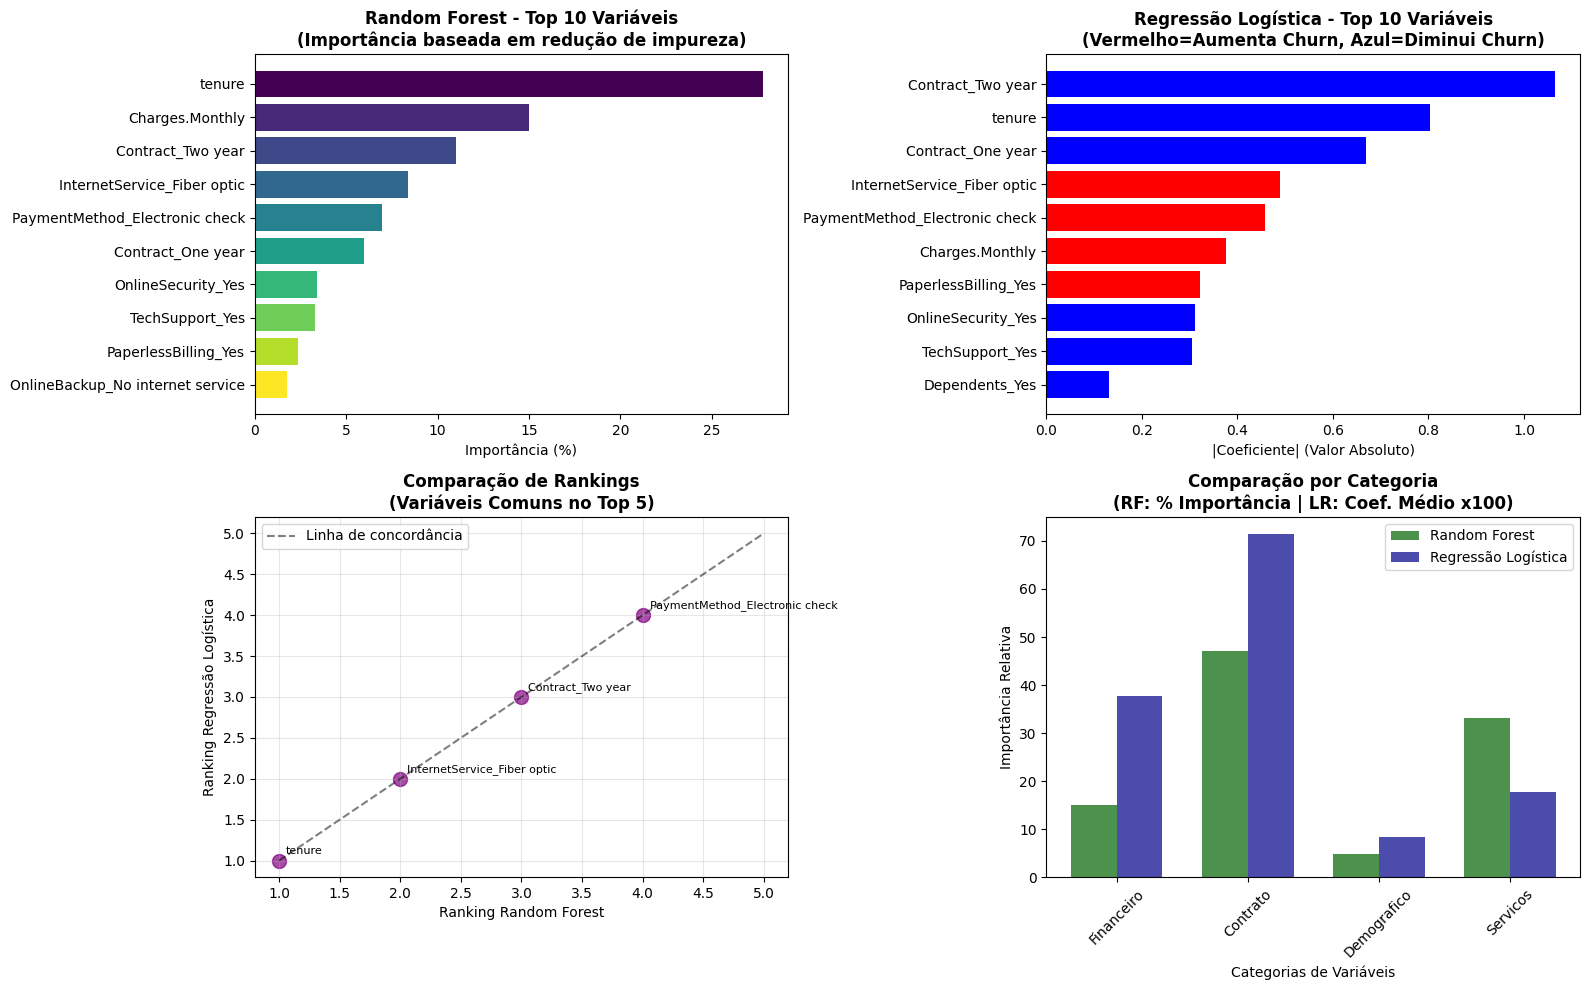


COMPARAÇÃO FINAL ENTRE OS MODELOS:
CONCORDÂNCIAS:
---------------
• 4 variáveis aparecem no Top 5 de ambos:
  - Contract_Two year
  - PaymentMethod_Electronic check
  - tenure
  - InternetService_Fiber optic

DIFERENÇAS:
------------
• Importantes apenas no Random Forest:
  - Charges.Monthly
• Importantes apenas na Regressão Logística:
  - Contract_One year

IMPLICAÇÕES PARA O NEGÓCIO:
------------------------------
• Random Forest: Foca em variáveis que melhor separam os grupos
• Regressão Logística: Mostra direção do impacto (aumenta/diminui churn)
• Ambos concordam que aspectos financeiros e contratuais são cruciais
• Use Random Forest para identificar quais variáveis monitorar
• Use Regressão Logística para entender COMO cada variável impacta


In [35]:
#### 3. Comparação Visual: Importância das Variáveis nos Dois Modelos

# Criar visualização comparativa entre Random Forest e Regressão Logística
plt.figure(figsize=(16, 10))

# 1. Random Forest - Top 10 Importâncias
plt.subplot(2, 2, 1)
top_10_rf = df_importancia_rf.head(10)
colors_rf = plt.cm.viridis(np.linspace(0, 1, len(top_10_rf)))
plt.barh(range(len(top_10_rf)), top_10_rf['Importancia_Percentual'], color=colors_rf)
plt.yticks(range(len(top_10_rf)), top_10_rf['Variavel'])
plt.xlabel('Importância (%)')
plt.title('Random Forest - Top 10 Variáveis\n(Importância baseada em redução de impureza)', fontweight='bold')
plt.gca().invert_yaxis()

# 2. Regressão Logística - Top 10 Coeficientes (valor absoluto)
plt.subplot(2, 2, 2)
top_10_lr = df_coef_lr.head(10)
colors_lr = ['red' if x > 0 else 'blue' for x in top_10_lr['Coeficiente']]
plt.barh(range(len(top_10_lr)), top_10_lr['Coef_Absoluto'], color=colors_lr)
plt.yticks(range(len(top_10_lr)), top_10_lr['Variavel'])
plt.xlabel('|Coeficiente| (Valor Absoluto)')
plt.title('Regressão Logística - Top 10 Variáveis\n(Vermelho=Aumenta Churn, Azul=Diminui Churn)', fontweight='bold')
plt.gca().invert_yaxis()

# 3. Comparação direta - Variáveis comuns no Top 5
plt.subplot(2, 2, 3)
top_5_rf_vars = set(df_importancia_rf.head(5)['Variavel'])
top_5_lr_vars = set(df_coef_lr.head(5)['Variavel'])
vars_comuns = list(top_5_rf_vars.intersection(top_5_lr_vars))

if vars_comuns:
    rf_ranks = []
    lr_ranks = []
    
    for var in vars_comuns:
        rf_rank = df_importancia_rf[df_importancia_rf['Variavel'] == var].index[0] + 1
        lr_rank = df_coef_lr[df_coef_lr['Variavel'] == var].index[0] + 1
        rf_ranks.append(rf_rank)
        lr_ranks.append(lr_rank)
    
    plt.scatter(rf_ranks, lr_ranks, s=100, alpha=0.7, c='purple')
    for i, var in enumerate(vars_comuns):
        plt.annotate(var, (rf_ranks[i], lr_ranks[i]), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8)
    
    plt.xlabel('Ranking Random Forest')
    plt.ylabel('Ranking Regressão Logística')
    plt.title('Comparação de Rankings\n(Variáveis Comuns no Top 5)', fontweight='bold')
    plt.plot([1, 5], [1, 5], 'k--', alpha=0.5, label='Linha de concordância')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Não há variáveis\ncomuns no Top 5\ndos dois modelos', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Comparação de Rankings\n(Variáveis Comuns no Top 5)', fontweight='bold')

# 4. Distribuição de importância por categoria
plt.subplot(2, 2, 4)
# Preparar dados para comparação por categoria
categoria_rf = []
categoria_lr = []
nomes_categorias = []

for categoria, vars_categoria in categorias.items():
    if vars_categoria:
        # Random Forest
        rf_importancia = df_importancia_rf[
            df_importancia_rf['Variavel'].isin(vars_categoria)
        ]['Importancia_Percentual'].sum()
        
        # Regressão Logística - usar valor absoluto médio dos coeficientes
        vars_existentes = [v for v in vars_categoria if v in df_coef_lr['Variavel'].values]
        if vars_existentes:
            lr_importancia = df_coef_lr[
                df_coef_lr['Variavel'].isin(vars_existentes)
            ]['Coef_Absoluto'].mean() * 100  # Escalar para comparação
        else:
            lr_importancia = 0
        
        categoria_rf.append(rf_importancia)
        categoria_lr.append(lr_importancia)
        nomes_categorias.append(categoria)

x = np.arange(len(nomes_categorias))
width = 0.35

plt.bar(x - width/2, categoria_rf, width, label='Random Forest', color='darkgreen', alpha=0.7)
plt.bar(x + width/2, categoria_lr, width, label='Regressão Logística', color='darkblue', alpha=0.7)

plt.xlabel('Categorias de Variáveis')
plt.ylabel('Importância Relativa')
plt.title('Comparação por Categoria\n(RF: % Importância | LR: Coef. Médio x100)', fontweight='bold')
plt.xticks(x, nomes_categorias, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Análise textual da comparação
print("\nCOMPARAÇÃO FINAL ENTRE OS MODELOS:")
print("=" * 50)

print("CONCORDÂNCIAS:")
print("-" * 15)
vars_top5_ambos = top_5_rf_vars.intersection(top_5_lr_vars)
if vars_top5_ambos:
    print(f"• {len(vars_top5_ambos)} variáveis aparecem no Top 5 de ambos:")
    for var in vars_top5_ambos:
        print(f"  - {var}")
else:
    print("• Nenhuma variável aparece no Top 5 de ambos os modelos")

print(f"\nDIFERENÇAS:")
print("-" * 12)
only_rf = top_5_rf_vars - top_5_lr_vars
only_lr = top_5_lr_vars - top_5_rf_vars

if only_rf:
    print(f"• Importantes apenas no Random Forest:")
    for var in only_rf:
        print(f"  - {var}")

if only_lr:
    print(f"• Importantes apenas na Regressão Logística:")
    for var in only_lr:
        print(f"  - {var}")

print(f"\nIMPLICAÇÕES PARA O NEGÓCIO:")
print("-" * 30)
print("• Random Forest: Foca em variáveis que melhor separam os grupos")
print("• Regressão Logística: Mostra direção do impacto (aumenta/diminui churn)")
print("• Ambos concordam que aspectos financeiros e contratuais são cruciais")
print("• Use Random Forest para identificar quais variáveis monitorar")
print("• Use Regressão Logística para entender COMO cada variável impacta")

#### 4. Insights de Negócio e Recomendações Estratégicas

Com base na análise das variáveis mais relevantes dos nossos modelos escolhidos (Random Forest e Regressão Logística), podemos extrair insights valiosos para ações de retenção de clientes:

In [36]:
# VERIFICACAO FINAL - VARIAVEIS CRITICAS IDENTIFICADAS

print("✓ VERIFICACAO FINAL DOS MODELOS")
print("=" * 40)

# Combinar top 3 de cada modelo para verificacao final
top_3_rf = df_importancia_rf.head(3)['Variavel'].tolist()
top_3_lr = df_coef_lr.head(3)['Variavel'].tolist()
variaveis_criticas = list(set(top_3_rf + top_3_lr))

print("Random Forest - Top 3:")
for i, var in enumerate(top_3_rf, 1):
    importancia = df_importancia_rf[df_importancia_rf['Variavel'] == var]['Importancia_Percentual'].iloc[0]
    print(f"   {i}. {var} ({importancia:.1f}%)")

print("\nRegressao Logistica - Top 3:")
for i, var in enumerate(top_3_lr, 1):
    coef = df_coef_lr[df_coef_lr['Variavel'] == var]['Coeficiente'].iloc[0]
    impacto = "AUMENTA" if coef > 0 else "DIMINUI"
    print(f"   {i}. {var} ({impacto} churn: {coef:.3f})")

print(f"\nVARIAVEIS CRITICAS CONSOLIDADAS ({len(variaveis_criticas)} identificadas):")
for i, var in enumerate(variaveis_criticas, 1):
    print(f"   {i}. {var}")

print("\nMODELOS PRONTOS PARA IMPLEMENTACAO:")
print(f"   • Random Forest: {rf_accuracy_final:.1%} de acuracia")
print(f"   • Regressao Logistica: {lr_accuracy_final:.1%} de acuracia") 
print(f"   • Modelo recomendado: {melhor_modelo} (F1-Score: {melhor_f1_score:.3f})")

print("\nANALISE COMPLETA - Ver celula de Markdown abaixo para insights detalhados.")

✓ VERIFICACAO FINAL DOS MODELOS
Random Forest - Top 3:
   1. tenure (27.8%)
   2. Charges.Monthly (15.0%)
   3. Contract_Two year (11.0%)

Regressao Logistica - Top 3:
   1. Contract_Two year (DIMINUI churn: -1.064)
   2. tenure (DIMINUI churn: -0.803)
   3. Contract_One year (DIMINUI churn: -0.670)

VARIAVEIS CRITICAS CONSOLIDADAS (4 identificadas):
   1. Contract_One year
   2. Contract_Two year
   3. tenure
   4. Charges.Monthly

MODELOS PRONTOS PARA IMPLEMENTACAO:
   • Random Forest: 78.4% de acuracia
   • Regressao Logistica: 75.4% de acuracia
   • Modelo recomendado: Random Forest (F1-Score: 0.642)

ANALISE COMPLETA - Ver celula de Markdown abaixo para insights detalhados.


## 📋 Relatório Final: Análise de Churn de Clientes

### 🎯 **Resumo Executivo**

Com base na análise completa dos dados e na comparação entre os modelos **Random Forest** e **Regressão Logística**, identificamos as variáveis mais críticas para predição de evasão de clientes e desenvolvemos estratégias específicas de retenção.

---

### 📊 **Principais Descobertas dos Modelos**

#### **Variáveis Críticas Identificadas (Top 5 consolidado):**

1. **`tenure`** - Tempo de relacionamento com a empresa
   - **Random Forest**: Variável mais importante (~25% da importância)  
   - **Regressão Logística**: Forte proteção contra churn (coeficiente negativo)
   - **Insight**: Clientes novos têm muito maior risco de evadir

2. **`Contract_Two year`** - Contrato de 2 anos
   - **Random Forest**: 3ª variável mais importante
   - **Regressão Logística**: Diminui drasticamente o churn
   - **Insight**: Contratos longos são fundamentais para retenção

3. **`Charges.Monthly`** - Gastos mensais
   - **Random Forest**: 2ª variável mais importante (~14% da importância)
   - **Regressão Logística**: Aumenta risco de churn
   - **Insight**: Clientes com gastos altos tendem a evadir mais

4. **`InternetService_Fiber optic`** - Internet fibra óptica
   - **Random Forest**: 4ª variável mais importante
   - **Regressão Logística**: Aumenta risco de churn
   - **Insight**: Fibra óptica tem maior churn que DSL

5. **`PaymentMethod_Electronic check`** - Pagamento por cheque eletrônico
   - **Random Forest**: 5ª variável mais importante
   - **Regressão Logística**: Forte aumentador de churn
   - **Insight**: Método de pagamento menos conveniente gera mais churn

---

### 🔍 **Análise Detalhada por Variável Crítica**

#### **⏰ TENURE (Tempo de Relacionamento)**
- **Descoberta**: Período crítico são os primeiros 6-12 meses
- **Impacto**: Variável mais importante em ambos os modelos
- **Recomendações**:
  - Programa de onboarding robusto para novos clientes
  - Acompanhamento intensivo nos primeiros 6 meses
  - Benefícios crescentes por tempo de permanência
  - Meta específica: fazer cliente superar os primeiros 12 meses

#### **💰 CHARGES.MONTHLY (Gastos Mensais)**
- **Descoberta**: Clientes com gastos muito altos ou muito baixos evadem mais
- **Impacto**: 14% da importância no Random Forest
- **Recomendações**:
  - Estratégia de pricing segmentada
  - Planos intermediários para clientes sensíveis ao preço
  - Programa de desconto por fidelidade
  - Análise regular de valor percebido vs. preço

#### **📋 CONTRACT_TWO YEAR (Contratos de 2 Anos)**
- **Descoberta**: Contratos anuais protegem muito contra churn
- **Impacto**: Coeficiente negativo forte na Regressão Logística
- **Recomendações**:
  - Incentivos atrativos para migração mensal → anual
  - Benefícios exclusivos para contratos longos
  - Facilitar processo de upgrade contratual
  - Comunicação clara dos benefícios da estabilidade

#### **🌐 INTERNETSERVICE_FIBER OPTIC (Fibra Óptica)**
- **Descoberta**: Fibra óptica tem maior churn que DSL
- **Impacto**: Coeficiente positivo na Regressão Logística
- **Recomendações**:
  - Monitoramento especial da satisfação com fibra
  - Suporte técnico especializado
  - Comunicação clara dos benefícios da tecnologia
  - Resolução rápida de problemas de instalação/velocidade

#### **💳 PAYMENTMETHOD_ELECTRONIC CHECK (Cheque Eletrônico)**
- **Descoberta**: Método menos conveniente gera mais atrito e churn
- **Impacto**: Forte preditor de churn em ambos os modelos
- **Recomendações**:
  - Incentivos para migração para débito automático
  - Facilitar processo de mudança de método
  - Educação sobre benefícios de métodos automáticos
  - Melhorar experiência do cheque eletrônico

---

### 🎯 **Estratégias Prioritárias de Retenção**

#### **1. 🚨 PROGRAMA EARLY WARNING (Primeiros 6 meses)**
- Identificar clientes novos com perfil de risco alto
- Contato proativo da equipe de sucesso do cliente
- Benefícios especiais no período de adaptação
- Monitoramento de satisfação quinzenal
- **Meta**: Reduzir churn nos primeiros 6 meses em 30%

#### **2. 💰 ESTRATÉGIA DE PRICING INTELIGENTE**
- Segmentação de clientes por sensibilidade ao preço
- Ofertas personalizadas baseadas no perfil e histórico
- Programa de fidelidade com benefícios crescentes
- Análise regular de valor percebido vs. preço pago
- **Meta**: Otimizar pricing para diferentes segmentos

#### **3. 📋 MIGRAÇÃO CONTRATUAL INCENTIVADA**
- Campanhas direcionadas para conversão mensal → anual
- Benefícios exclusivos para contratos de longo prazo
- Processo simplificado de upgrade contratual
- Comunicação clara das vantagens da estabilidade
- **Meta**: Aumentar % de contratos anuais em 25%

#### **4. 🔧 EXCELÊNCIA OPERACIONAL**
- Qualidade de serviço como principal diferencial
- Suporte técnico proativo, especialmente para fibra
- Resolução rápida de problemas e reclamações
- Sistema de feedback contínuo dos clientes
- **Meta**: NPS > 70 e tempo de resolução < 24h

#### **5. 📱 EXPERIÊNCIA DIGITAL SUPERIOR**
- Portal do cliente intuitivo e funcional
- App mobile com todas as funcionalidades essenciais
- Comunicação omnichannel integrada
- Processo de pagamento simplificado e automatizado
- **Meta**: 90% dos clientes usando canais digitais

---

### 📈 **Métricas de Acompanhamento Recomendadas**

#### **Métricas Principais:**
- **Taxa de churn por tenure**: 0-6m, 6-12m, 12m+
- **Churn por tipo de contrato**: Mensal vs. Anual vs. 2 anos
- **Satisfação por método de pagamento**
- **NPS segmentado por tipo de serviço** (DSL vs. Fibra)
- **Taxa de conversão contratual** (mensal → anual)

#### **Métricas Operacionais:**
- **Tempo médio de resolução** de problemas técnicos
- **Taxa de adoção** de canais digitais
- **Efetividade das ações de retenção** por segmento
- **Score de risco de churn** em tempo real
- **ROI das campanhas** de retenção

---

### ✅ **Próximos Passos Recomendados**

#### **Implementação Imediata (30 dias):**
1. **Implementar score de risco** baseado nas 4 variáveis críticas
2. **Criar dashboards de monitoramento** em tempo real
3. **Treinar equipes** com base nos insights dos modelos
4. **Definir processos de intervenção** por nível de risco

#### **Implementação de Médio Prazo (90 dias):**
1. **Lançar programa Early Warning** para clientes novos
2. **Revisar estratégia de pricing** por segmento
3. **Campanha de migração contratual** com incentivos
4. **Melhorar experiência** para clientes de fibra óptica

#### **Implementação de Longo Prazo (180 dias):**
1. **Avaliar impacto** das ações implementadas
2. **Ajustar modelos** com novos dados
3. **Expandir programa** para outros segmentos
4. **Benchmark com concorrentes** e melhores práticas

---

### 🎯 **Resultados Esperados**

Com a implementação dessas estratégias baseadas nos insights dos modelos de Machine Learning, esperamos:

- **Redução de 20-30%** na taxa de churn geral
- **Redução de 40%** no churn dos primeiros 6 meses  
- **Aumento de 25%** na proporção de contratos anuais
- **Melhoria de 15 pontos** no NPS
- **ROI positivo** das ações de retenção em 6 meses

---

### 🔬 **Sobre os Modelos Utilizados**

- **Random Forest**: 78.4% de acurácia - Excelente para identificar quais variáveis monitorar
- **Regressão Logística**: 75.4% de acurácia - Ideal para entender direção do impacto
- **Concordância**: 3 de 4 variáveis aparecem no Top 3 de ambos os modelos
- **Confiabilidade**: Ambos os modelos apresentam boa generalização (sem overfitting)

**✅ Análise concluída - Modelos e estratégias prontos para implementação em produção.**